# R2S Analysis

Jupyter notebook for the analysis of radial updates in the context of the two-site Hubbard model.  
Naturally, utilizing this notebook requires access to the data and the path has to be provided in the next cell.  
While this notebook should suffice to recreate all the analysis steps starting from the raw data (i.e. the files given in "R2S/data"), actually running all of the postprocessing steps will take quite a lot of time. Therefore, the intermediate postprocessed data is already provided in "R2S/postpro_data".  

### Specifiy glob_path to link to the data folder

In [3]:
glob_path = ""

data_path = glob_path + "R2S/data/"
postpro_path = glob_path + "R2S/postpro_data/"
plot_path = glob_path + "R2S/plots/"

### Import modules and necessary custom functions

In [4]:
### Import modules
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from functools import partial
import os
import time
%matplotlib inline

### Import custom functions
from utils import save_arrays, round_to_n, round_to_n_of_err, get_parentheses_error_notation, sep, get_NSL_lattices_from_h5, get_NSL_correlators_from_h5
from observable_funcs import load_comp_save_obs, mean_obs, abs_mean_obs, compute_time_slice_radius, compute_radius
from analysis_funcs import full_ac_fits, ac_analysis_detM, plot_and_fit_sigmin, Nt_autocorrelation_analysis, R2S_correlator_autocorr_analysis
from R2S_funcs import full_two_site_dist, full_one_site_dist

### Define custom colors for plotting
my_blue = (2/255, 61/255, 107/255)
my_red = (217/255, 85/255, 20/255)
my_green = (163/255, 201/255, 0/255)
my_violet = (100/255, 2/255, 107/255)
my_brown = (107/255, 47/255, 2/255)
cs = [my_blue, my_red, my_green, my_violet, my_brown, "tab:blue", "tab:green", "tab:orange", "tab:red"]


# Contour plots

### Two sites, one time slice

In [3]:
### Load data
Nconf = int(1e4)
n_skip = 1

path = data_path + "Nt1/Radial_2Site_Nt1_sig00_Nmd60.h5"
full_data = get_NSL_lattices_from_h5(path, Nconf = int(Nconf))
Phi = np.sum(np.reshape(full_data, (Nconf, 1, 2)), axis = 1)
Nt1_sig0_data = Phi[::n_skip, :]

path = data_path + "Nt1/Radial_2Site_Nt1_sig18_Nmd60.h5"
full_data = get_NSL_lattices_from_h5(path, Nconf = int(Nconf))
Phi = np.sum(np.reshape(full_data, (Nconf, 1, 2)), axis = 1)
Nt1_sig18_data = Phi[::n_skip, :]



In [4]:
U, beta = 18, 1
delta = 0.02

X_twosite, Y_twosite, Z_twosite, a, normed_marginal_dist = full_two_site_dist(lim = 25, dx = delta, U = U, beta = beta, Nt = 1, kappa = 1)

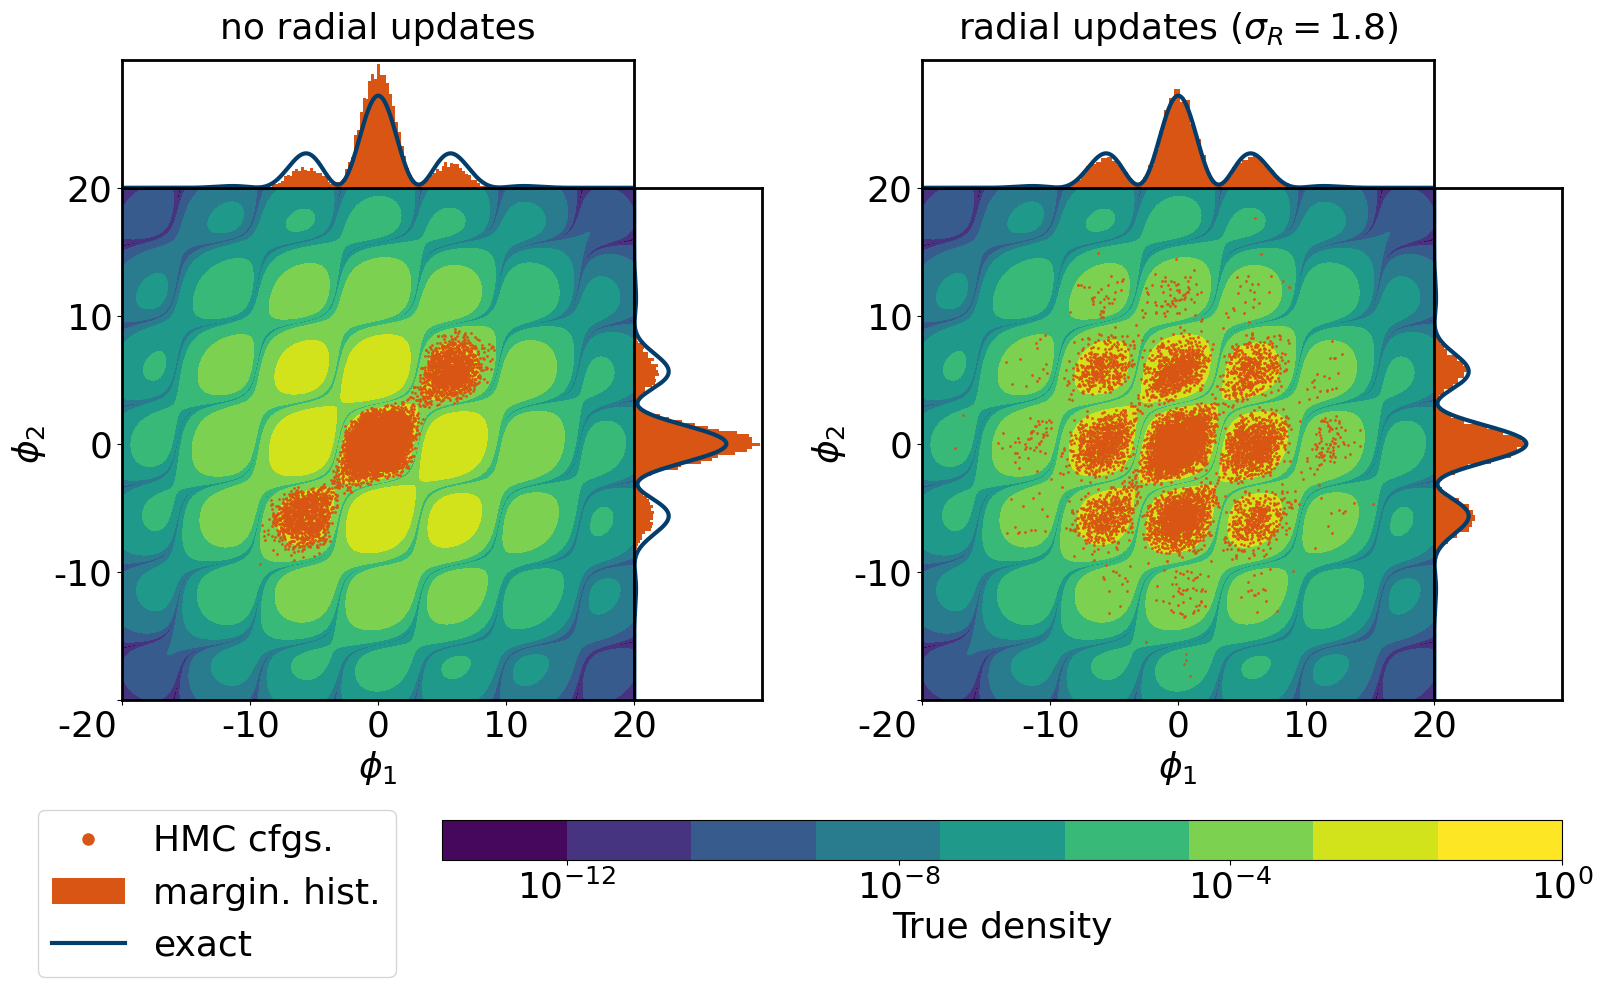

In [5]:
### Plot Settings

fs = 26
lw = 3
Nt = 1
kappa = 1
beta = 1
U = 18

bins = 90
lim = 20
bin_lim = 15
plot_off = -13

fig = plt.figure(figsize = (16, 8))
subfigs = fig.subfigures(1, 2, wspace = 0.0)

gs1 = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.0, hspace=0.0)
ax1 = subfigs[0].add_subplot(gs1[1,0], aspect = "equal")
ax1_hist_x = subfigs[0].add_subplot(gs1[0, 0], sharex = ax1) #
ax1_hist_y = subfigs[0].add_subplot(gs1[1, 1], sharey = ax1) #

log10_Z_twosite = np.clip(np.log10(np.real(Z_twosite)), a_min = plot_off, a_max = None)
CS = ax1.contourf(X_twosite, Y_twosite, log10_Z_twosite, vmin = plot_off, vmax = np.amax(log10_Z_twosite))
for c in CS.collections:
    c.set_rasterized(True)

ax1.scatter(Nt1_sig0_data[:, 0], Nt1_sig0_data[:, 1], s = 1, color = cs[1])
ax1_hist_x.hist(Nt1_sig0_data[:, 0], density = True, color = my_red, alpha = 1., bins = bins, range = (-bin_lim, bin_lim), label = r"margin. hist.")
ax1_hist_y.hist(Nt1_sig0_data[:, 1], density = True, color = my_red, alpha = 1.0, bins = bins, range = (-bin_lim, bin_lim), label = r"$\phi_2$", orientation = "horizontal")
ax1_hist_x.plot(a, normed_marginal_dist, label = "exact", color = my_blue, linewidth = lw)
ax1_hist_y.plot(normed_marginal_dist, a, label = "exact", color = my_blue, linewidth = lw)

# ax1_hist_x.legend(loc = "upper left", fontsize = fs - 12)

ax1.plot([-30], [-30], marker = "o", color = my_red, markersize = 8, linestyle = "", label = "HMC cfgs.")
ax1.hist(Nt1_sig0_data[:10, 1]-60, density = True, color = my_red, alpha = 1.0, bins = bins, rwidth = 0.5, label = r"margin. hist.", orientation = "horizontal")
ax1.plot([-30], [-30], marker = "", color = my_blue, markersize = 1, linestyle = "-", linewidth = lw, label = "exact")
ax1.legend(loc = "upper left", bbox_to_anchor = (-0.2, -0.18), fontsize = fs)
# ax1.legend(loc = "upper right", bbox_to_anchor = (3.705, 1.4), fontsize = fs)



gs2 = subfigs[1].add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.0, hspace=0.0)
ax2 = subfigs[1].add_subplot(gs2[1,0], aspect = "equal")
ax2_hist_x = subfigs[1].add_subplot(gs2[0, 0], sharex = ax2) #
ax2_hist_y = subfigs[1].add_subplot(gs2[1, 1], sharey = ax2) #

CS = ax2.contourf(X_twosite, Y_twosite, log10_Z_twosite, vmin = plot_off, vmax = np.amax(log10_Z_twosite))
for c in CS.collections:
    c.set_rasterized(True)

ax2.scatter(Nt1_sig18_data[:, 0], Nt1_sig18_data[:, 1], s = 1, color = cs[1])
ax2_hist_x.hist(Nt1_sig18_data[:, 0], density = True, color = my_red, alpha = 1., bins = bins, range = (-bin_lim, bin_lim), label = r"$\phi_1$")
ax2_hist_y.hist(Nt1_sig18_data[:, 1], density = True, color = my_red, alpha = 1.0, bins = bins, range = (-bin_lim, bin_lim), label = r"$\phi_2$", orientation = "horizontal")
ax2_hist_x.plot(a, normed_marginal_dist, label = "exact", color = my_blue, linewidth = lw)
ax2_hist_y.plot(normed_marginal_dist, a, label = "exact", color = my_blue, linewidth = lw)
# ax2.plot([-30], [-30], marker = "o", color = my_red, markersize = 6, label = "HMC traj.")
# ax2.legend(loc = "upper left", fontsize = fs-4)

ax1.set_xlim(-lim, lim), ax1.set_ylim(-lim, lim)
ax2.set_xlim(-lim, lim), ax2.set_ylim(-lim, lim)

temp = [-20, -10, 0, 10, 20]
man_temp_labels = ["   -20", "-10", "0", "10", "20"]
man_temp_labels = ["-20      ", "-10", "0", "10", "20"]
temp2 = [0.0, 0.1, 0.2]

ax1_hist_x.tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
ax1_hist_y.tick_params(axis = "y", which = "both", left = False, top = False, labelleft = False)
ax1_hist_y.tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
ax1_hist_x.tick_params(axis = "y", which = "both", left = False, top = False, labelleft = False)

ax2_hist_x.tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
ax2_hist_y.tick_params(axis = "y", which = "both", left = False, top = False, labelleft = False)
ax2_hist_y.tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
ax2_hist_x.tick_params(axis = "y", which = "both", left = False, top = False, labelleft = False)

# ax1_hist_x.set_xticks(temp, ["" for x in temp], fontsize = fs)
ax1_hist_x.set_yticks(temp2, ["" for x in temp2], fontsize = fs)
ax1_hist_y.set_xticks(temp2, ["" for x in temp2], fontsize = fs)
# ax1_hist_y.set_yticks(temp, ["" for x in temp], fontsize = fs)

# ax2_hist_x.set_xticks(temp, ["" for x in temp], fontsize = fs)
ax2_hist_x.set_yticks(temp2, ["" for x in temp2], fontsize = fs)
ax2_hist_y.set_xticks(temp2, ["" for x in temp2], fontsize = fs)
# ax2_hist_y.set_yticks(temp, ["" for x in temp], fontsize = fs)

# ax1.set_xticks(temp, [str(x) for x in temp], fontsize = fs)
# ax2.set_xticks(temp, [str(x) for x in temp], fontsize = fs)
ax1.set_xticks(temp, man_temp_labels, fontsize = fs)
ax2.set_xticks(temp, man_temp_labels, fontsize = fs)
man_temp_labels2 = ["", "-10", "0", "10", "20"]
ax1.set_yticks(temp, man_temp_labels2, fontsize = fs)
ax2.set_yticks(temp, man_temp_labels2, fontsize = fs)
# ax1.set_yticks(temp, [str(x) for x in temp], fontsize = fs)
# ax2.set_yticks(temp, [str(x) for x in temp], fontsize = fs)


ax1.set_xlabel(r"$\phi_1$", fontsize = fs)
ax1.set_ylabel(r"$\phi_2$", fontsize = fs)
ax2.set_xlabel(r"$\phi_1$", fontsize = fs)
ax2.set_ylabel(r"$\phi_2$", fontsize = fs)

# ax1_hist_x.set_xlim(-lim, lim), ax1_hist_y.set_ylim(-lim, lim)
# ax2_hist_x.set_xlim(-lim, lim), ax2_hist_y.set_ylim(-lim, lim)

ax1_hist_x.set_ylim(0., 0.25), ax1_hist_y.set_xlim(0., 0.25)
ax2_hist_x.set_ylim(0., 0.25), ax2_hist_y.set_xlim(0., 0.25)

# ax1_hist_x.set_yscale("log"), ax1_hist_y.set_xscale("log"), ax2_hist_x.set_yscale("log"), ax2_hist_y.set_xscale("log")


spinewidth = 2
for spine in ax1.spines.values():
    spine.set_linewidth(spinewidth)
for spine in ax1_hist_x.spines.values():
    spine.set_linewidth(spinewidth)
for spine in ax1_hist_y.spines.values():
    spine.set_linewidth(spinewidth)
for spine in ax2.spines.values():
    spine.set_linewidth(spinewidth)
for spine in ax2_hist_x.spines.values():
    spine.set_linewidth(spinewidth)
for spine in ax2_hist_y.spines.values():
    spine.set_linewidth(spinewidth)
    
# ax1_hist_x.spines["bottom"].set_linewidth(spinewidth)
# ax1_hist_y.spines["left"].set_linewidth(spinewidth)
    
    
ax1_hist_x.set_title("no radial updates", fontsize = fs, pad = 15)
ax2_hist_x.set_title(r"radial updates ($\sigma_R = 1.8$)", fontsize = fs, pad = 15)

# cbar_ax = fig.add_axes([0.6, 0.1, 0.8, 0.2])
cbar_ax = fig.add_axes([0.25, -0.1, 0.7, 0.05])
# cbar = fig.colorbar(CS, ax = subfigs, orientation = "horizontal", fraction = 0.05, pad = 0.1)
cbar = fig.colorbar(CS, cax=cbar_ax, orientation = "horizontal", fraction = 0.05, pad = 0.1)
cbar.set_label("True density", size = fs)
cbar.ax.tick_params(labelsize = fs)
cbar.set_ticks([0, -4, -8, -12], labels = [r"$10^{0}$", r"$10^{-4}$", r"$10^{-8}$", r"$10^{-12}$"])

# plt.savefig(plot_path + "R2S_Nt1_scatter_margin.pdf", dpi = 600, bbox_inches = "tight")
plt.show()

### Multiple time slices

In [6]:
### Load data
Nconf = 100000 
n_skip = 10

path = data_path + "Nt8/Radial_2Site_Nt8_sig00_Nmd50.h5"

full_data = get_NSL_lattices_from_h5(path, Nconf = int(Nconf))
Phi = np.sum(np.reshape(full_data, (Nconf, 8, 2)), axis = 1)
Nt8_sig0_data = Phi[::n_skip, :]

path = data_path + "Nt8/Radial_2Site_Nt8_sig06_Nmd50.h5"
full_data = get_NSL_lattices_from_h5(path, Nconf = int(Nconf))
Phi = np.sum(np.reshape(full_data, (Nconf, 8, 2)), axis = 1)
Nt8_sig06_data = Phi[::n_skip, :]



In [9]:
U, beta = 18, 1
X_onesite, Y_onesite, Z_onesite, a, normed_marginal_dist = full_one_site_dist(lim = 25, dx = 0.04, U = U, beta = beta)

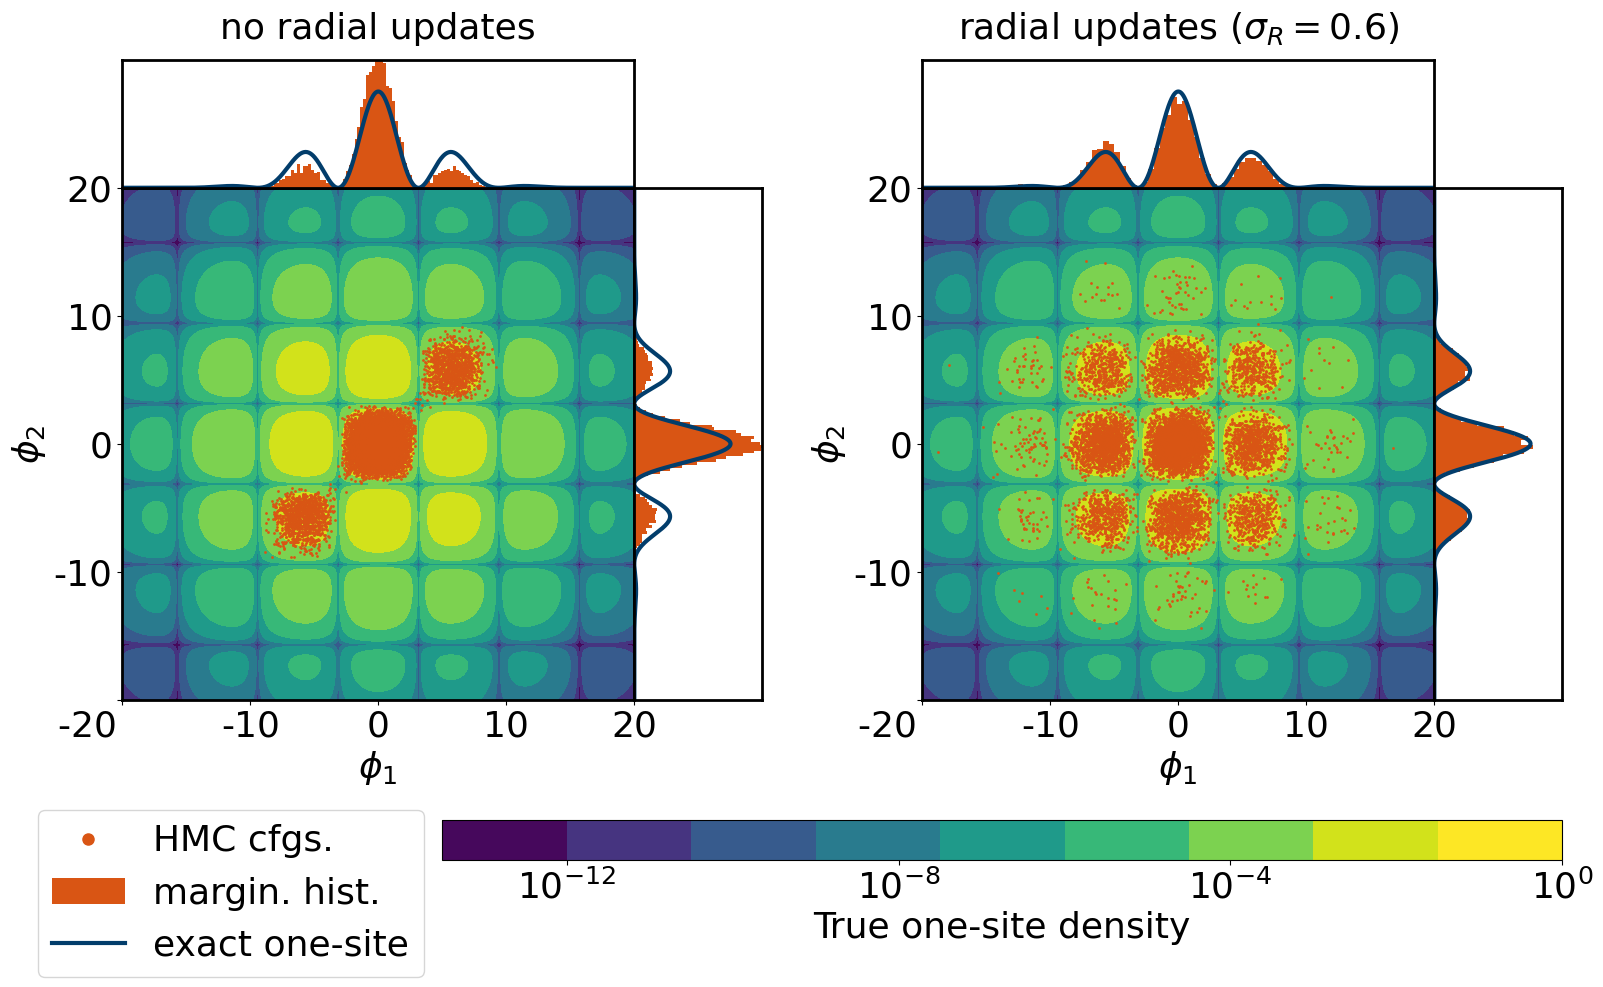

In [8]:
### Plot Settings
my_blue = (2/255, 61/255, 107/255)
my_red = (217/255, 85/255, 20/255)
my_green = (163/255, 201/255, 0/255)

fs = 26
lw = 3
Nt = 1
kappa = 1
beta = 1
U = 18

bins = 90
lim = 15
bin_lim = 15
plot_off = -13

fig = plt.figure(figsize = (16, 8))
subfigs = fig.subfigures(1, 2, wspace = 0.0)

gs1 = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.0, hspace=0.0)
ax1 = subfigs[0].add_subplot(gs1[1,0], aspect = "equal")
ax1_hist_x = subfigs[0].add_subplot(gs1[0, 0], sharex = ax1) #
ax1_hist_y = subfigs[0].add_subplot(gs1[1, 1], sharey = ax1) #


log10_Z_onesite = np.clip(np.log10(np.real(Z_onesite)), a_min = plot_off, a_max = None)
CS = ax1.contourf(X_onesite, Y_onesite, log10_Z_onesite, vmin = plot_off, vmax = np.amax(log10_Z_onesite))
for c in CS.collections:
    c.set_rasterized(True)
    
ax1.scatter(Nt8_sig0_data[:, 0], Nt8_sig0_data[:, 1], s = 1, color = cs[1])
ax1_hist_x.hist(Nt8_sig0_data[:, 0], density = True, color = my_red, alpha = 1., bins = bins, range = (-bin_lim, bin_lim), label = r"margin. hist.")
ax1_hist_y.hist(Nt8_sig0_data[:, 1], density = True, color = my_red, alpha = 1.0, bins = bins, range = (-bin_lim, bin_lim), label = r"$\phi_2$", orientation = "horizontal")
ax1_hist_x.plot(a, normed_marginal_dist, label = "exact 1site", color = my_blue, linewidth = lw)
ax1_hist_y.plot(normed_marginal_dist, a, label = "exact 1site", color = my_blue, linewidth = lw)

# ax1_hist_x.legend(loc = "upper left", fontsize = fs - 12)

ax1.plot([-30], [-30], marker = "o", color = my_red, markersize = 8, linestyle = "", label = "HMC cfgs.")
ax1.hist(Nt8_sig0_data[:10, 1]-60, density = True, color = my_red, alpha = 1.0, bins = bins, rwidth = 0.5, label = r"margin. hist.", orientation = "horizontal")
ax1.plot([-30], [-30], marker = "", color = my_blue, markersize = 1, linestyle = "-", linewidth = lw, label = "exact one-site")
ax1.legend(loc = "upper left", bbox_to_anchor = (-0.2, -0.18), fontsize = fs)
# ax1.legend(loc = "upper right", bbox_to_anchor = (3.705, 1.4), fontsize = fs)



gs2 = subfigs[1].add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.0, hspace=0.0)
ax2 = subfigs[1].add_subplot(gs2[1,0], aspect = "equal")
ax2_hist_x = subfigs[1].add_subplot(gs2[0, 0], sharex = ax2) #
ax2_hist_y = subfigs[1].add_subplot(gs2[1, 1], sharey = ax2) #


CS = ax2.contourf(X_onesite, Y_onesite, log10_Z_onesite, vmin = plot_off, vmax = np.amax(log10_Z_onesite))
for c in CS.collections:
    c.set_rasterized(True)
    
ax2.scatter(Nt8_sig06_data[:, 0], Nt8_sig06_data[:, 1], s = 1, color = cs[1])
ax2_hist_x.hist(Nt8_sig06_data[:, 0], density = True, color = my_red, alpha = 1., bins = bins, range = (-bin_lim, bin_lim), label = r"$\phi_1$")
ax2_hist_y.hist(Nt8_sig06_data[:, 1], density = True, color = my_red, alpha = 1.0, bins = bins, range = (-bin_lim, bin_lim), label = r"$\phi_2$", orientation = "horizontal")
ax2_hist_x.plot(a, normed_marginal_dist, label = "exact 1site", color = my_blue, linewidth = lw)
ax2_hist_y.plot(normed_marginal_dist, a, label = "exact 1site", color = my_blue, linewidth = lw)
# ax2.plot([-30], [-30], marker = "o", color = my_red, markersize = 6, label = "HMC traj.")
# ax2.legend(loc = "upper left", fontsize = fs-4)

ax1.set_xlim(-lim, lim), ax1.set_ylim(-lim, lim)
ax2.set_xlim(-lim, lim), ax2.set_ylim(-lim, lim)

temp = [-20, -10, 0, 10, 20]
man_temp_labels = ["   -20", "-10", "0", "10", "20"]
man_temp_labels = ["-20      ", "-10", "0", "10", "20"]
temp2 = [0.0, 0.1, 0.2]

ax1_hist_x.tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
ax1_hist_y.tick_params(axis = "y", which = "both", left = False, top = False, labelleft = False)
ax1_hist_y.tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
ax1_hist_x.tick_params(axis = "y", which = "both", left = False, top = False, labelleft = False)

ax2_hist_x.tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
ax2_hist_y.tick_params(axis = "y", which = "both", left = False, top = False, labelleft = False)
ax2_hist_y.tick_params(axis = "x", which = "both", bottom = False, top = False, labelbottom = False)
ax2_hist_x.tick_params(axis = "y", which = "both", left = False, top = False, labelleft = False)

# ax1_hist_x.set_xticks(temp, ["" for x in temp], fontsize = fs)
ax1_hist_x.set_yticks(temp2, ["" for x in temp2], fontsize = fs)
ax1_hist_y.set_xticks(temp2, ["" for x in temp2], fontsize = fs)
# ax1_hist_y.set_yticks(temp, ["" for x in temp], fontsize = fs)

# ax2_hist_x.set_xticks(temp, ["" for x in temp], fontsize = fs)
ax2_hist_x.set_yticks(temp2, ["" for x in temp2], fontsize = fs)
ax2_hist_y.set_xticks(temp2, ["" for x in temp2], fontsize = fs)
# ax2_hist_y.set_yticks(temp, ["" for x in temp], fontsize = fs)

# ax1.set_xticks(temp, [str(x) for x in temp], fontsize = fs)
# ax2.set_xticks(temp, [str(x) for x in temp], fontsize = fs)
ax1.set_xticks(temp, man_temp_labels, fontsize = fs)
ax2.set_xticks(temp, man_temp_labels, fontsize = fs)
man_temp_labels2 = ["", "-10", "0", "10", "20"]
ax1.set_yticks(temp, man_temp_labels2, fontsize = fs)
ax2.set_yticks(temp, man_temp_labels2, fontsize = fs)
# ax1.set_yticks(temp, [str(x) for x in temp], fontsize = fs)
# ax2.set_yticks(temp, [str(x) for x in temp], fontsize = fs)


ax1.set_xlabel(r"$\phi_1$", fontsize = fs)
ax1.set_ylabel(r"$\phi_2$", fontsize = fs)
ax2.set_xlabel(r"$\phi_1$", fontsize = fs)
ax2.set_ylabel(r"$\phi_2$", fontsize = fs)

# ax1_hist_x.set_xlim(-lim, lim), ax1_hist_y.set_ylim(-lim, lim)
# ax2_hist_x.set_xlim(-lim, lim), ax2_hist_y.set_ylim(-lim, lim)

ax1_hist_x.set_ylim(0., 0.25), ax1_hist_y.set_xlim(0., 0.25)
ax2_hist_x.set_ylim(0., 0.25), ax2_hist_y.set_xlim(0., 0.25)

# ax1_hist_x.set_yscale("log"), ax1_hist_y.set_xscale("log"), ax2_hist_x.set_yscale("log"), ax2_hist_y.set_xscale("log")


spinewidth = 2
for spine in ax1.spines.values():
    spine.set_linewidth(spinewidth)
for spine in ax1_hist_x.spines.values():
    spine.set_linewidth(spinewidth)
for spine in ax1_hist_y.spines.values():
    spine.set_linewidth(spinewidth)
for spine in ax2.spines.values():
    spine.set_linewidth(spinewidth)
for spine in ax2_hist_x.spines.values():
    spine.set_linewidth(spinewidth)
for spine in ax2_hist_y.spines.values():
    spine.set_linewidth(spinewidth)
    
# ax1_hist_x.spines["bottom"].set_linewidth(spinewidth)
# ax1_hist_y.spines["left"].set_linewidth(spinewidth)
    
    
ax1_hist_x.set_title("no radial updates", fontsize = fs, pad = 15)
ax2_hist_x.set_title(r"radial updates ($\sigma_R = 0.6$)", fontsize = fs, pad = 15)

# cbar_ax = fig.add_axes([0.6, 0.1, 0.8, 0.2])
cbar_ax = fig.add_axes([0.25, -0.1, 0.7, 0.05])
# cbar = fig.colorbar(CS, ax = subfigs, orientation = "horizontal", fraction = 0.05, pad = 0.1)
cbar = fig.colorbar(CS, cax=cbar_ax, orientation = "horizontal", fraction = 0.05, pad = 0.1)
cbar.set_label("True one-site density", size = fs)
cbar.ax.tick_params(labelsize = fs)
cbar.set_ticks([0, -4, -8, -12], labels = [r"$10^{0}$", r"$10^{-4}$", r"$10^{-8}$", r"$10^{-12}$"])

# plt.savefig(plot_path + "R2S_Nt8_scatter_margin.pdf", dpi = 600, bbox_inches = "tight")
plt.show()

### Information on all performed simulations, necessary to locate and identify files.

In [5]:
sig_Nt1 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 
           1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 
           2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0]
sig_Nt4 = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 
           1.2, 1.4, 1.6, 1.8, 2.0, 2.5, 3.0]
sig_Nt8 = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 
           1.0, 1.2, 1.4, 1.5, 1.6, 1.8, 2.0, 3.0, 4.0]
sig_Nt16 = [0.0, 0.02, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.5, 1.7, 2.0]
sig_Nt24 = [0.0, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
sig_Nt32 = [0.0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.3, 2.0]
sig_Nt40 = [0.0, 0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0, 1.2, 1.5, 2.0]

# Dictionary with all simulations
sim_dict = {}
sim_dict[f"Nt1"] = {"Nmd" : 60, "Nconf" : int(2e5), "sigma" : sig_Nt1}
sim_dict[f"Nt4"] = {"Nmd" : 50, "Nconf" : int(2e5), "sigma" : sig_Nt4}
sim_dict[f"Nt8"] = {"Nmd" : 50, "Nconf" : int(3e5), "sigma" : sig_Nt8}
sim_dict[f"Nt16"] = {"Nmd" : 40, "Nconf" : int(3e5), "sigma" : sig_Nt16}
sim_dict[f"Nt24"] = {"Nmd" : 45, "Nconf" : int(3e5), "sigma" : sig_Nt24}
sim_dict[f"Nt32"] = {"Nmd" : 40, "Nconf" : int(4e5), "sigma" : sig_Nt32}
sim_dict[f"Nt40"] = {"Nmd" : 45, "Nconf" : int(5e5), "sigma" : sig_Nt40}


# Data postprocessing

### Compute observables

In [29]:
Nt_ = [1, 4, 8, 16, 24, 32, 40]

t1 = time.time()
for Nt in Nt_:
    obs_dict = {"mean" : mean_obs, 
                "radius" : compute_radius, 
                "TimeSliceRadius" : partial(compute_time_slice_radius, Nt = Nt, Nx = 2)}
    sig_ = sim_dict[f"Nt{Nt}"]["sigma"]
    Nconf = sim_dict[f"Nt{Nt}"]["Nconf"]
    Nmd = sim_dict[f"Nt{Nt}"]["Nmd"]
    for sig in sig_:
        path = data_path + f"Nt{Nt}/Radial_2Site_Nt{Nt}_sig"+str(sig).replace(".", "")+f"_Nmd{Nmd}.h5"
        csv_path = postpro_path + f"Nt{Nt}/R2S_Nt{Nt}_sig"+str(sig).replace(".", "p")+"_obs.csv"
        load_comp_save_obs(path, obs_dict, Nconf_max = Nconf, csv_path = csv_path)
    print(f"Nt={Nt} done after {round(time.time()-t1, 2)}s")
    

### Autocorrelation analysis for previously computed observables.  
Careful, plotting results will lead to a lot of plots.

In [5]:
Nt_ = [1, 4, 8, 16, 24, 32, 40]

for Nt in Nt_:
    Nt_autocorrelation_analysis(Nt = Nt, 
                                sig_ = sim_dict[f"Nt{Nt}"]["sigma"], 
                                analysis_name = "R2S", 
                                postpro_path = postpro_path, 
                                plot_path = plot_path, 
                                plot_results = False)

### Autocorrelation analysis for correlators.  
Compute integrated autocorrelation time for all components of correlators

In [28]:
Nt_ = [1, 4, 8, 16, 24, 32, 40]
# Nt_ = [16]
split_subplots_dict = {"Nt1" : (1,1), "Nt4" : (2,2), "Nt8" : (2,4), "Nt16" : (4,4), "Nt24" : (4,6), "Nt32" : (4,8), "Nt40" : (5,8)}
show_plots = True

for Nt in Nt_:
    sig_ = sim_dict[f"Nt{Nt}"]["sigma"]
    Nconf_max = sim_dict[f"Nt{Nt}"]["Nconf"]
    Nmd = sim_dict[f"Nt{Nt}"]["Nmd"]
    n_corr = 2
    sn1, sn2 = split_subplots_dict[f"Nt{Nt}"]

    data = np.zeros((3, len(sig_), Nt, 2, 5))
    t1 = time.time()
    for i, sig in enumerate(sig_):
        path = data_path + f"Nt{Nt}/Radial_2Site_Nt{Nt}_sig"+str(sig).replace(".", "")+f"_Nmd{Nmd}.h5"        
        full_corr = np.real(get_NSL_correlators_from_h5(path, Nt, Nconf_max))

        for corr_ind in range(n_corr):
            tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_ = R2S_correlator_autocorr_analysis(full_corr, 
                                                                                                     Nt = Nt, split_n1 = sn1, split_n2 = sn2, 
                                                                                                     S = 1.0, 
                                                                                                     use_first_zero_crossing = False, 
                                                                                                     save_plot = plot_path + f"ac/Nt{Nt}/R2S_Nt{Nt}_sig"+str(sig).replace(".", "p")+f"_full_corr{corr_ind}_ac", 
                                                                                                     suptitle = rf"$\sigma = {sig}$; $N_t={Nt}$; $S=1$", 
                                                                                                     corr_ind = corr_ind)
            save_fname = postpro_path + f"Nt{Nt}/R2S_Nt{Nt}_sig"+str(sig).replace(".", "p")+f"_full_corr{corr_ind}_ac_S1.txt"
            save_arrays(save_fname, ["obs", "stderr", "tint", "dtint", "W"], False, tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_)
            ac_crit_ind = 0
            data[ac_crit_ind, i, :, corr_ind, 0], data[ac_crit_ind, i, :, corr_ind, 1], data[ac_crit_ind, i, :, corr_ind, 2], data[ac_crit_ind, i, :, corr_ind, 3], data[ac_crit_ind, i, :, corr_ind, 4] = tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_

            tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_ = R2S_correlator_autocorr_analysis(full_corr, 
                                                                                                     Nt = Nt, split_n1 = sn1, split_n2 = sn2, 
                                                                                                     S = 1.0, 
                                                                                                     use_first_zero_crossing = True, 
                                                                                                     save_plot = plot_path + f"ac/Nt{Nt}/R2S_Nt{Nt}_sig"+str(sig).replace(".", "p")+f"_full_corr{corr_ind}_ac_zc", 
                                                                                                     suptitle = rf"$\sigma = {sig}$; $N_t={Nt}$; zero-crossing", 
                                                                                                     corr_ind = corr_ind)
            save_fname = postpro_path + f"Nt{Nt}/R2S_Nt{Nt}_sig"+str(sig).replace(".", "p")+f"_full_corr{corr_ind}_ac_zc.txt"
            save_arrays(save_fname, ["obs", "stderr", "tint", "dtint", "W"], False, tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_)
            ac_crit_ind = 1
            data[ac_crit_ind, i, :, corr_ind, 0], data[ac_crit_ind, i, :, corr_ind, 1], data[ac_crit_ind, i, :, corr_ind, 2], data[ac_crit_ind, i, :, corr_ind, 3], data[ac_crit_ind, i, :, corr_ind, 4] = tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_

            tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_ = R2S_correlator_autocorr_analysis(full_corr, 
                                                                                                     Nt = Nt, split_n1 = sn1, split_n2 = sn2, 
                                                                                                     c = 10.0, 
                                                                                                     use_first_zero_crossing = False, 
                                                                                                     save_plot = plot_path + f"ac/Nt{Nt}/R2S_Nt{Nt}_sig"+str(sig).replace(".", "p")+f"_full_corr{corr_ind}_ac_c10p0", 
                                                                                                     suptitle = rf"$\sigma = {sig}$; $N_t={Nt}$; $c = {10}$", 
                                                                                                     corr_ind = corr_ind)
            save_fname = postpro_path + f"Nt{Nt}/R2S_Nt{Nt}_sig"+str(sig).replace(".", "p")+f"_full_corr{corr_ind}_ac_c10p0.txt"
            save_arrays(save_fname, ["obs", "stderr", "tint", "dtint", "W"], False, tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_)
            ac_crit_ind = 2
            data[ac_crit_ind, i, :, corr_ind, 0], data[ac_crit_ind, i, :, corr_ind, 1], data[ac_crit_ind, i, :, corr_ind, 2], data[ac_crit_ind, i, :, corr_ind, 3], data[ac_crit_ind, i, :, corr_ind, 4] = tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_

        print(f"Sigma {sig} done after {round(time.time()-t1, 2)}s. ")
    print(f"Nt={Nt} done after {round(time.time()-t1, 2)}s. ")
    sep()




Reduce integrated autocorrelation times to a single value for the correlator

In [24]:
Nt_ = [1, 4, 8, 16, 24, 32, 40]

ac_crits = {"S1" : r"$S=1$", "zc" : "zc", "c10p0" : r"$c=10$"}

marker_ = ["o", "s", "x"]

n_corr = 2
fs = 16

for j, Nt in enumerate(Nt_):
    sig_ = sim_dict[f"Nt{Nt}"]["sigma"]
    tint_coll_tmp = np.zeros((len(ac_crits), n_corr, 2, len(sig_)))
    tint_err_coll_tmp = np.zeros((len(ac_crits), n_corr, 2, len(sig_)))
    for new_ind, (ac_key, ac_label) in enumerate(ac_crits.items()):
        for corr_ind in range(n_corr):
            for i, sig in enumerate(sig_):
                path = postpro_path + f"Nt{Nt}/R2S_Nt{Nt}_sig"+str(sig).replace(".", "p")+f"_full_corr{corr_ind}_ac_"+ac_key+".txt"
                obs, stderr, tint, dtint, W = np.loadtxt(path, usecols = (0, 1, 2, 3, 4), skiprows = 1, unpack = True)
                tint_coll_tmp[new_ind, corr_ind, 0, i] = np.mean(tint)
                lvals = 1 if Nt==1 else dtint.shape[0]
                tint_err_coll_tmp[new_ind, corr_ind, 0, i] = np.sqrt(np.sum(np.power(dtint, 2)))/lvals
                max_ind = np.argmax(tint).item()
                tint_coll_tmp[new_ind, corr_ind, 1, i] = tint if Nt==1 else tint[max_ind]
                tint_err_coll_tmp[new_ind, corr_ind, 1, i] = dtint if Nt==1 else dtint[max_ind]
            header = ["sig", "tint", "dtint"]  
            path = postpro_path + f"Nt{Nt}/R2S_Nt{Nt}_corr{corr_ind}_ac_"+ac_key+"_rc_mean.txt"
            save_arrays(path, header, False, sig_, tint_coll_tmp[new_ind, corr_ind, 0, :], tint_err_coll_tmp[new_ind, corr_ind, 0, :])
            path = postpro_path + f"Nt{Nt}/R2S_Nt{Nt}_corr{corr_ind}_ac_"+ac_key+"_rc_max.txt"
            save_arrays(path, header, False, sig_, tint_coll_tmp[new_ind, corr_ind, 1, :], tint_err_coll_tmp[new_ind, corr_ind, 1, :])
            



### Autocorrelation analysis for sgndetM observable.

In [25]:
Nt_ = [1, 4, 8, 16, 24, 32, 40]

def get_data_string(sig, Nt, Nmd, data_path):
    return data_path + f"Nt{Nt}/Radial_2Site_Nt{Nt}_sig"+str(sig).replace(".", "")+f"_Nmd{Nmd}_detM.txt"


for i, Nt in enumerate(Nt_):
    sig_ = sim_dict[f"Nt{Nt}"]["sigma"]
    Nmd = sim_dict[f"Nt{Nt}"]["Nmd"]
    partial_get_data_string = partial(get_data_string, Nt = Nt, Nmd = Nmd, data_path = data_path)
    ac_data_array = ac_analysis_detM(Nt = Nt, 
                                     data_str_f = partial_get_data_string, 
                                     sig_ = sig_, 
                                     analysis_name = "R2S", 
                                     postpro_path = postpro_path, 
                                     plot_path = plot_path, 
                                     plot_results = False)


# Integrated autocorrelation time fits; $\tau_{\mathrm{int}}(\sigma_R)=a\sigma_R^{-2} + b + c\sigma_R$

Dictionaries with functions to get the data and information on fitting procedure.

In [7]:
R2S_acfit_dict = {}

radius_name = r"$\mathcal{O}_\Phi=\sqrt{\sum_x \left(\sum_t\phi_{tx}\right)^2}$"
charge_name = r"$\mathcal{O}_Q=\sum_{t,x} \phi_{tx}/d$"
corr_name = r"$\mathcal{O}_C=C_{-}(\tau)$"
sgndetM_name = r"$\mathrm{sgn} f[i\phi]$"

def get_tsradius_data(Nt, ac_name, postpro_path):
    path = postpro_path + f"Nt{Nt}/R2S_Nt{Nt}_TimeSliceRadius_ac_"+ac_name+".csv"
    df = pd.read_csv(path)
    data = df.to_numpy()
    sigma, obs, stderr, tint, tinterr = data[:, 0], data[:, 1], data[:, 3], data[:, 5], data[:, 6]
    return (sigma, obs, stderr, tint, tinterr)

def get_charge_data(Nt, ac_name, postpro_path):
    path = postpro_path + f"Nt{Nt}/R2S_Nt{Nt}_mean_ac_"+ac_name+".csv"
    df = pd.read_csv(path)
    data = df.to_numpy()
    sigma, obs, stderr, tint, tinterr = data[:, 0], data[:, 1], data[:, 3], data[:, 5], data[:, 6]
    return (sigma, obs, stderr, tint, tinterr)

def get_corr_data(Nt, corr_ind, ac_name, rc_name, postpro_path):
    path = postpro_path + f"Nt{Nt}/R2S_Nt{Nt}_corr{corr_ind}_ac_"+ac_name+"_rc_"+rc_name+".txt"
    sigma, tint, tinterr = np.loadtxt(path, usecols = (0, 1, 2), skiprows = 1, unpack = True)
    obs, stderr = None, None
    return (sigma, obs, stderr, tint, tinterr)
    
def get_sgndetM_data(Nt, ac_name, postpro_path):
    path = postpro_path + f"Nt{Nt}/R2S_Nt{Nt}_detM_ac_"+ac_name+".txt"
    sigma, obs, stderr, tint, tinterr = np.loadtxt(path, usecols = (0, 1, 3, 5, 6), skiprows = 1, unpack = True)
    return (sigma, obs, stderr, tint, tinterr)
    
ac_name = "S1" # autocorrelation analysis criterion 
corr_ac_name = "zc" # autocorrelation analysis criterion for correlator
rc_name = "max" # reduction criterion for correlator
corr_ind = 0

Nt = 1
tmp_dict = {}
tmp_dict["TimeSliceRadius"] = {"data" : get_tsradius_data(Nt, ac_name, postpro_path), "obs_name" : radius_name, "outlier_inds" : [0, 1], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Charge"] = {"data" : get_charge_data(Nt, ac_name, postpro_path), "obs_name" : charge_name, "outlier_inds" : [0, 1, 2, 3], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator"] = {"data" : get_corr_data(Nt, corr_ind, corr_ac_name, rc_name, postpro_path), "obs_name" : corr_name, "outlier_inds" : [0, 1, 2], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["sgndetM"] = {"data" : get_sgndetM_data(Nt, ac_name, postpro_path), "obs_name" : sgndetM_name, "outlier_inds" : [0, 1], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
R2S_acfit_dict[f"Nt{Nt}"] = tmp_dict

Nt = 4
tmp_dict = {}
tmp_dict["TimeSliceRadius"] = {"data" : get_tsradius_data(Nt, ac_name, postpro_path), "obs_name" : radius_name, "outlier_inds" : [0, 1, 2], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Charge"] = {"data" : get_charge_data(Nt, ac_name, postpro_path), "obs_name" : charge_name, "outlier_inds" : [0, 1, 2, 3, 4, 5], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator"] = {"data" : get_corr_data(Nt, corr_ind, corr_ac_name, rc_name, postpro_path), "obs_name" : corr_name, "outlier_inds" : [0, 1, 2, 3, 4], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["sgndetM"] = {"data" : get_sgndetM_data(Nt, ac_name, postpro_path), "obs_name" : sgndetM_name, "outlier_inds" : [0, 1, 2, 3], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
R2S_acfit_dict[f"Nt{Nt}"] = tmp_dict

Nt = 8
tmp_dict = {}
tmp_dict["TimeSliceRadius"] = {"data" : get_tsradius_data(Nt, ac_name, postpro_path), "obs_name" : radius_name, "outlier_inds" : [0, 1, 2, 3], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Charge"] = {"data" : get_charge_data(Nt, ac_name, postpro_path), "obs_name" : charge_name, "outlier_inds" : [0, 1, 2, 3, 4, 5], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator"] = {"data" : get_corr_data(Nt, corr_ind, corr_ac_name, rc_name, postpro_path), "obs_name" : corr_name, "outlier_inds" : [0, 1, 2, 3], "xticks" : None, "yticks" : ([3, 6, 10, 20], [r"$3\times 10^0$", r"$6\times 10^0$", r"$10^1$", r"$2\times 10^1$"]), "xlim" : None, "ylim" : None}
tmp_dict["sgndetM"] = {"data" : get_sgndetM_data(Nt, ac_name, postpro_path), "obs_name" : sgndetM_name, "outlier_inds" : [0, 1, 2, 3], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
R2S_acfit_dict[f"Nt{Nt}"] = tmp_dict

Nt = 16
tmp_dict = {}
tmp_dict["TimeSliceRadius"] = {"data" : get_tsradius_data(Nt, ac_name, postpro_path), "obs_name" : radius_name, "outlier_inds" : [0, 1, 2, 3], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Charge"] = {"data" : get_charge_data(Nt, ac_name, postpro_path), "obs_name" : charge_name, "outlier_inds" : [0, 1, 2, 3, 4], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator"] = {"data" : get_corr_data(Nt, corr_ind, corr_ac_name, rc_name, postpro_path), "obs_name" : corr_name, "outlier_inds" : [0, 1, 2, 3, 4, -1], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["sgndetM"] = {"data" : get_sgndetM_data(Nt, ac_name, postpro_path), "obs_name" : sgndetM_name, "outlier_inds" : [0, 1, 2, 3, 4], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
R2S_acfit_dict[f"Nt{Nt}"] = tmp_dict

Nt = 24
tmp_dict = {}
tmp_dict["TimeSliceRadius"] = {"data" : get_tsradius_data(Nt, ac_name, postpro_path), "obs_name" : radius_name, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Charge"] = {"data" : get_charge_data(Nt, ac_name, postpro_path), "obs_name" : charge_name, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator"] = {"data" : get_corr_data(Nt, corr_ind, corr_ac_name, rc_name, postpro_path), "obs_name" : corr_name, "outlier_inds" : [0, 1, 2, 3, 4], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["sgndetM"] = {"data" : get_sgndetM_data(Nt, ac_name, postpro_path), "obs_name" : sgndetM_name, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
R2S_acfit_dict[f"Nt{Nt}"] = tmp_dict

Nt = 32
tmp_dict = {}
tmp_dict["TimeSliceRadius"] = {"data" : get_tsradius_data(Nt, ac_name, postpro_path), "obs_name" : radius_name, "outlier_inds" : [0, 1, 2, 3, 4, 5], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Charge"] = {"data" : get_charge_data(Nt, ac_name, postpro_path), "obs_name" : charge_name, "outlier_inds" : [0, 1, 2, 3, 4, 5], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator"] = {"data" : get_corr_data(Nt, corr_ind, corr_ac_name, rc_name, postpro_path), "obs_name" : corr_name, "outlier_inds" : [0, 1, 2, 3, 4, 5], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["sgndetM"] = {"data" : get_sgndetM_data(Nt, ac_name, postpro_path), "obs_name" : sgndetM_name, "outlier_inds" : [0, 1, 2], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
R2S_acfit_dict[f"Nt{Nt}"] = tmp_dict

Nt = 40
tmp_dict = {}
tmp_dict["TimeSliceRadius"] = {"data" : get_tsradius_data(Nt, ac_name, postpro_path), "obs_name" : radius_name, "outlier_inds" : [0, 1], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Charge"] = {"data" : get_charge_data(Nt, ac_name, postpro_path), "obs_name" : charge_name, "outlier_inds" : [0, 1], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator"] = {"data" : get_corr_data(Nt, corr_ind, corr_ac_name, rc_name, postpro_path), "obs_name" : corr_name, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["sgndetM"] = {"data" : get_sgndetM_data(Nt, ac_name, postpro_path), "obs_name" : sgndetM_name, "outlier_inds" : [0, 1, 2], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
R2S_acfit_dict[f"Nt{Nt}"] = tmp_dict


### Perform the fits and get estimates on $\sigma_R^{(\mathrm{min})}$ and $\tau_{\mathrm{int}}^{(\mathrm{min})}$

Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [2.83326927 1.37056177 0.97206507] [0.04804667 0.08146737 0.03120956]
Bootstrap fit [2.83443318 1.37081349 0.97176152] [0.04847604 0.08041767 0.03096472]
Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [0.01528631 0.6517322  0.06855766] [0.00219746 0.00961022 0.00459907]
Bootstrap fit [0.01526901 0.65196432 0.06845561] [0.00159416 0.00713801 0.00344494]


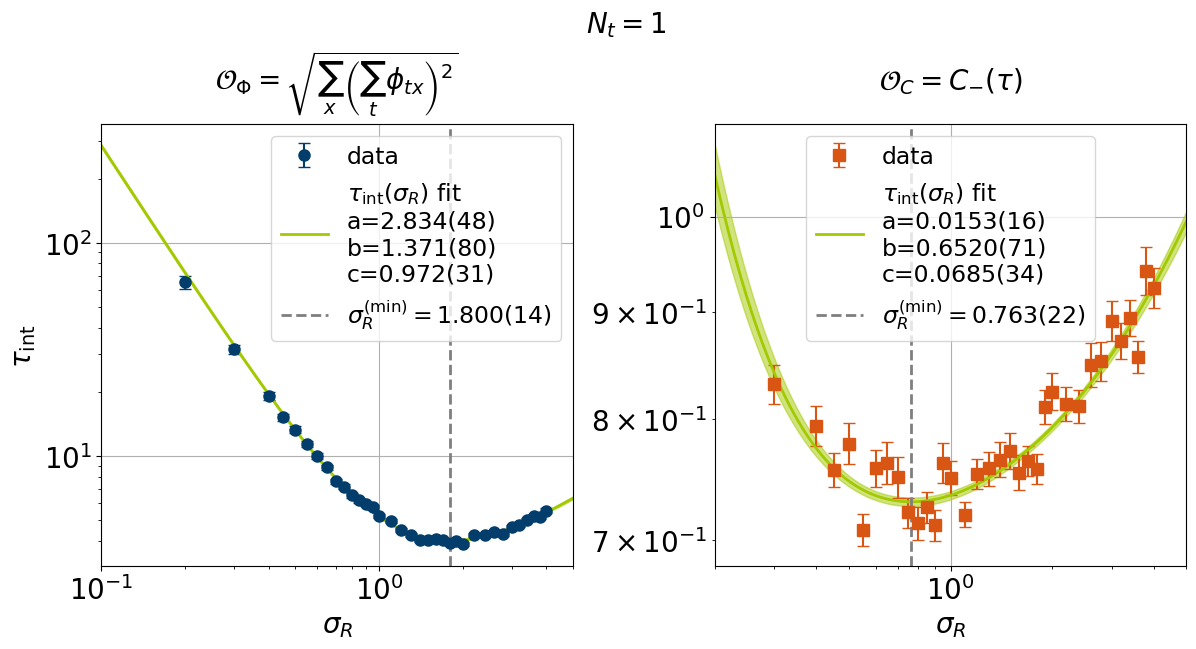

Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [ 3.81367451 21.90354802 12.30334705] [0.19353459 1.34315145 1.02952945]
Bootstrap fit [ 3.81100694 21.96242293 12.28192177] [0.21493183 1.45161528 1.12430402]
Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [0.06263648 0.87222243 0.24633928] [0.00614291 0.04868014 0.03778153]
Bootstrap fit [0.06287438 0.87147631 0.24695915] [0.003958   0.03167853 0.02427187]


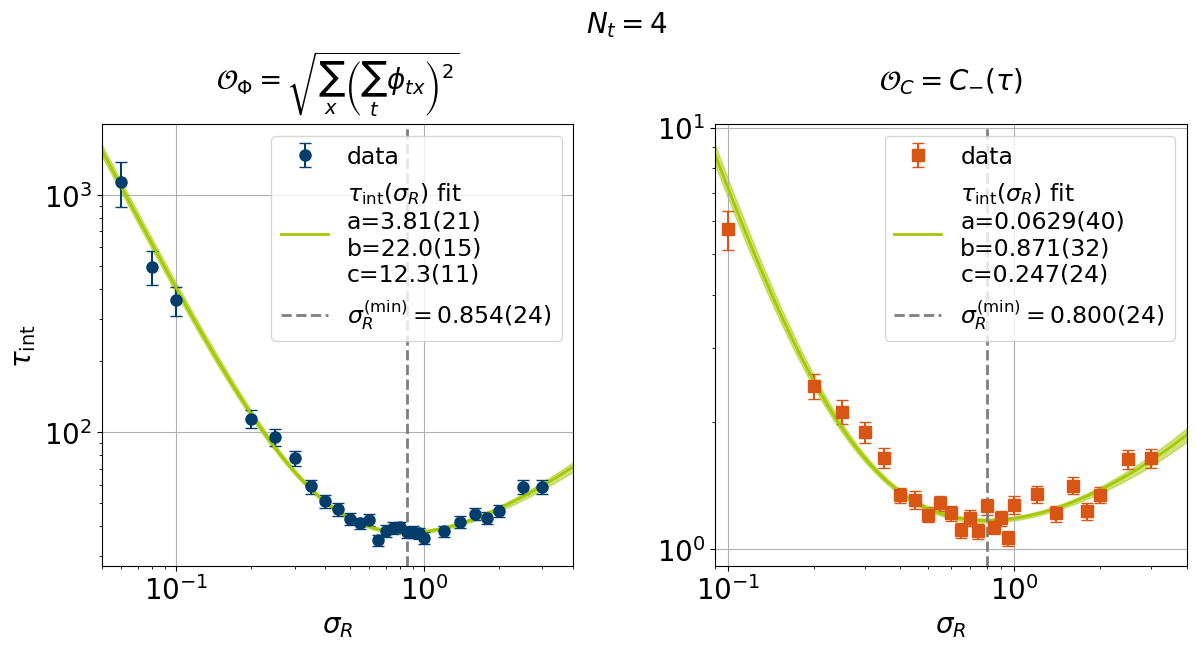

Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [ 4.7808913  65.85940548 48.37577735] [0.28275543 5.16635779 4.38777457]
Bootstrap fit [ 4.81174444 65.36871261 48.76701611] [0.31679273 5.58326303 4.69458136]
Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [0.0764126  1.93159354 0.85192266] [0.00700354 0.1487214  0.12204153]
Bootstrap fit [0.07690175 1.92286387 0.85909425] [0.00509028 0.1043477  0.08506468]


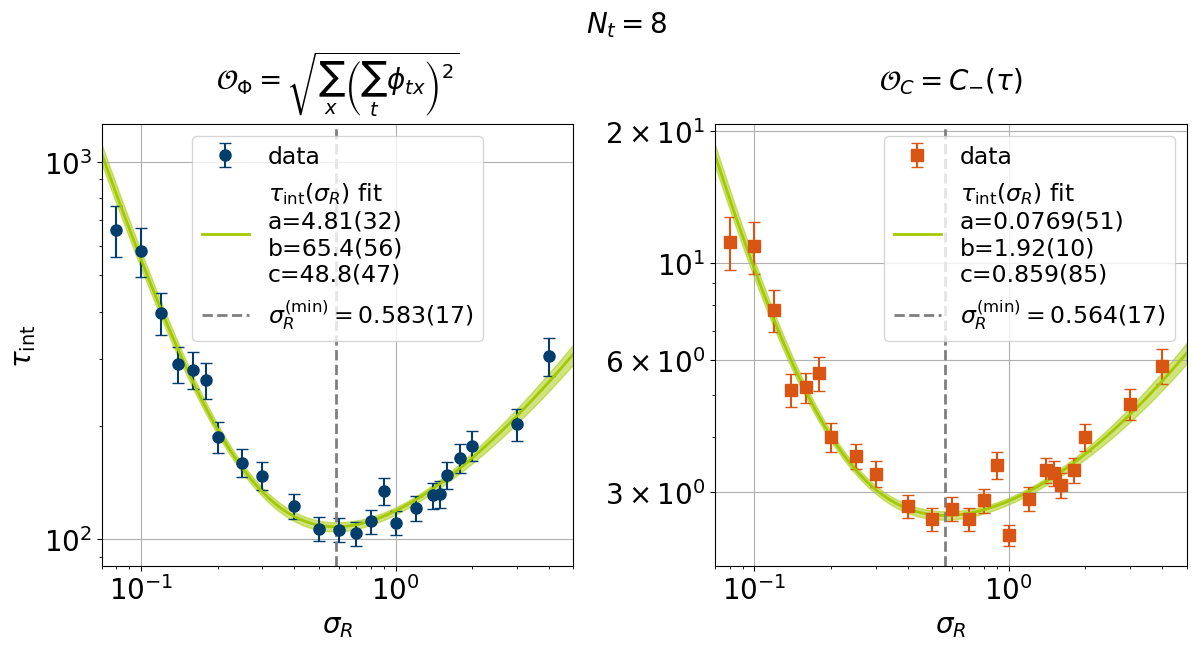

Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [  5.81188759 103.08812398 213.75104851] [ 0.62411857 22.32695202 29.17018851]
Bootstrap fit [  5.82118539 102.86577668 214.34205507] [ 0.58121422 20.09770455 26.42850016]
Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [ 0.73135666  4.77947228 25.12702427] [0.09628549 2.73478836 3.77460588]
Bootstrap fit [ 0.73921023  4.64762632 25.25958354] [0.09657062 2.72467986 3.79131712]


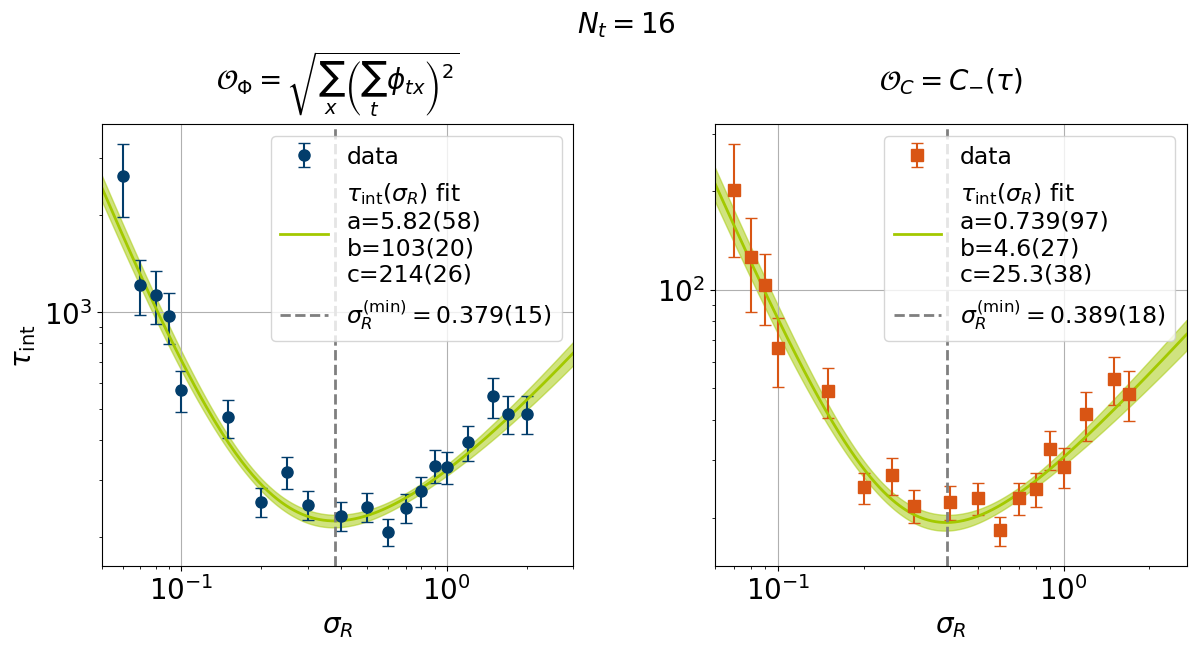

Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [  4.82756001 275.27716493 289.15074623] [ 0.81263606 55.10032437 68.21244831]
Bootstrap fit [  4.8282116  275.14455052 290.43955162] [ 0.63534769 42.17042855 52.3878825 ]
Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [ 0.76766805 19.40061492 29.50102304] [0.25009237 7.9926538  9.7767951 ]
Bootstrap fit [ 0.77560747 19.17398032 29.82852049] [0.16678669 5.37717177 6.67151794]


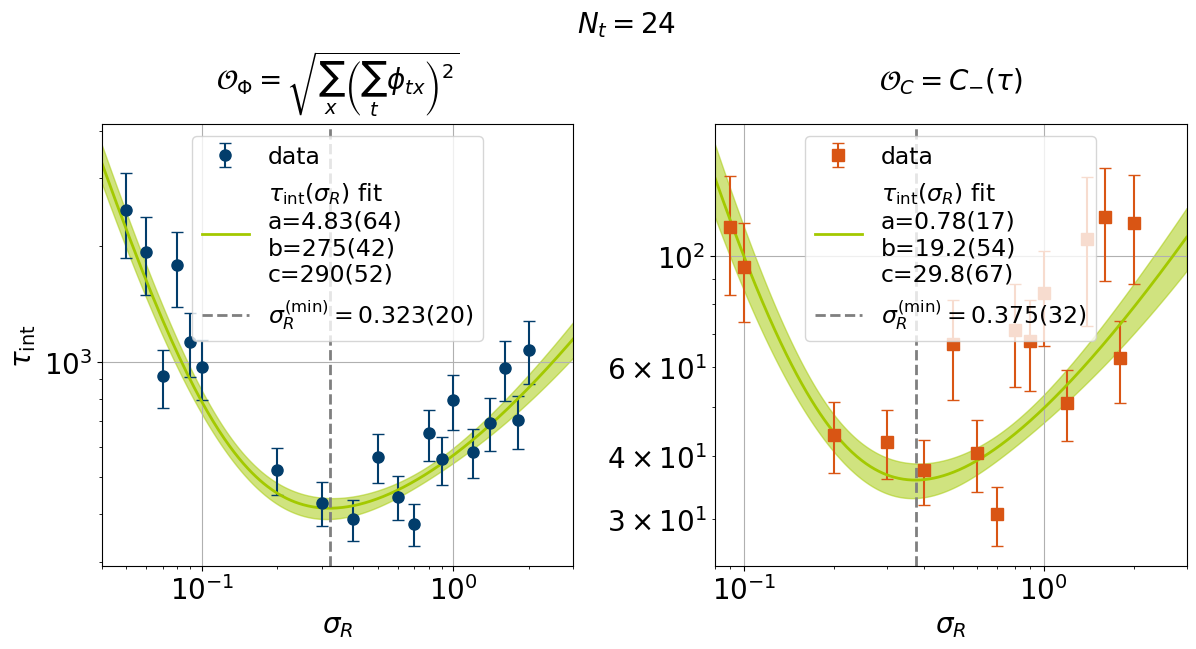

Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [  8.33898325 290.33544522 471.06640505] [ 1.20592009 54.14350116 83.5785137 ]
Bootstrap fit [  8.34034049 290.79215874 471.75646583] [ 1.1402237  49.09067854 76.23123585]
Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [ 1.09230372 16.62301383 57.74432766] [ 0.2623224  9.3221789 15.7516909]
Bootstrap fit [ 1.09272548 16.58502004 57.98912057] [ 0.1987443   6.91943808 11.72254013]


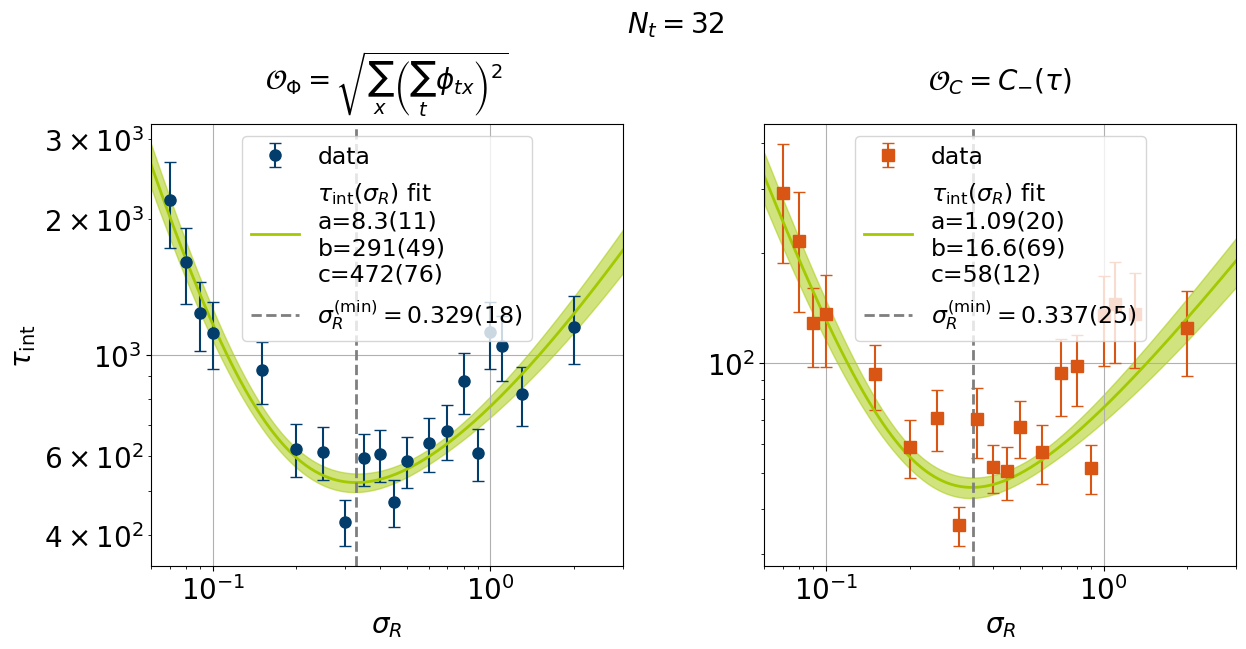

Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [  2.17068882 656.7483947  366.0983709 ] [  0.44793346  73.28509226 109.31610746]
Bootstrap fit [  2.18749482 657.66222649 362.67250735] [  0.4116951   67.74301206 101.81218536]
Fits skipped 3
Sigma min estimate 0.0 0.0
Curve fit [ 0.16079954 68.03815725 54.95595788] [ 0.04661568  8.73866089 15.55717127]
Bootstrap fit [ 0.16402915 67.81133427 54.9748707 ] [ 0.05266544 10.24858696 17.4344399 ]


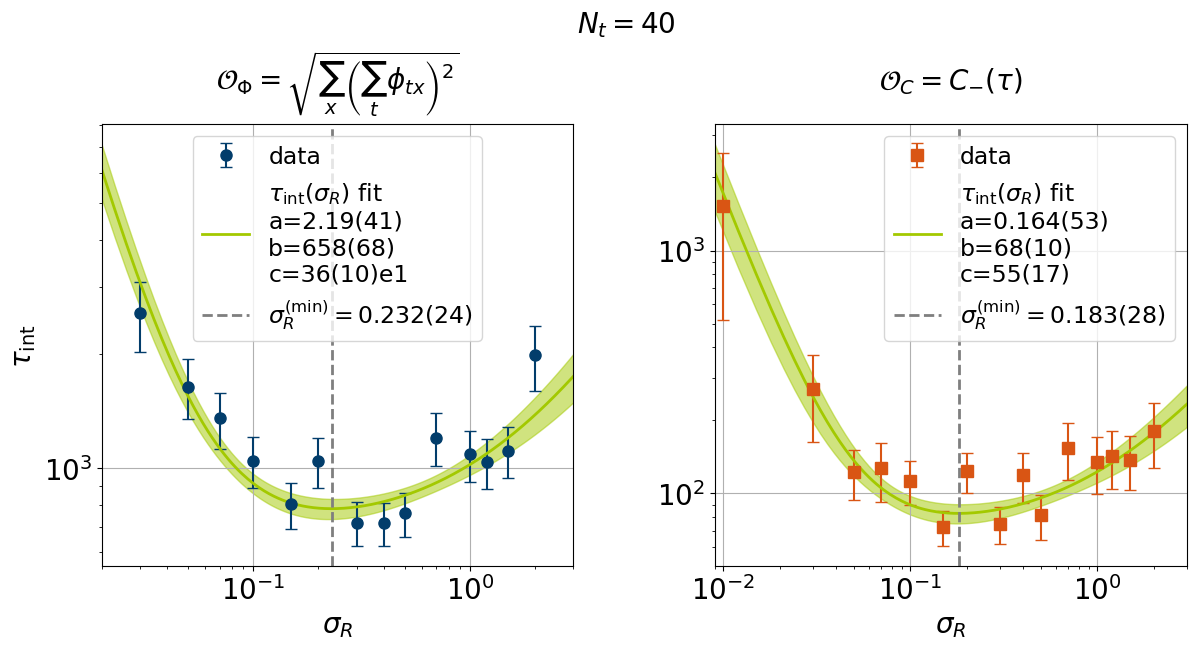

In [8]:
use_obs_dict = {"TimeSliceRadius" : True, 
                "Charge" : False, 
                "Correlator" : True, 
                "sgndetM" : False
                }

Nt_ = [1, 4, 8, 16, 24, 32, 40]

plot_obs = False # Also plot observables themselves; Does not work for correlator
weight_fits = True # Weight fits with chi-squared
save_plots = False
save_data = False

smin_boot_, smin_err_, tintmin_boot_, tintmin_err_ = full_ac_fits(Nt_ = Nt_, 
                                                                 use_obs_dict = use_obs_dict, 
                                                                 acfit_dict = R2S_acfit_dict, 
                                                                 plot_path = plot_path, 
                                                                 analysis_name = "R2S", 
                                                                 plot_obs = plot_obs, 
                                                                 n_bootstrap = 1000, 
                                                                 weight_fits = weight_fits, 
                                                                 save_plots = save_plots)


data = np.stack((np.repeat(np.expand_dims(Nt_, axis = 0), smin_boot_.shape[0], axis = 0), smin_boot_, smin_err_, tintmin_boot_, tintmin_err_), axis = 0)
if save_data:
    column_names = ["Nt", "sigma_min", "sigma_min_err", "tauint_min", "tauint_min_err"]
    i = 0
    for obs_name, obs_bool in use_obs_dict.items():
        if obs_bool:
            data_dict = {}
            for k, col_name in enumerate(column_names):
                data_dict[col_name] = data[k, i, :]
            df = pd.DataFrame(data_dict)
            rc_string = ("_" + rc_name) if obs_name=="Correlator" else "" 
            csv_fname = postpro_path + f"R2S_smin_tintmin_"+obs_name+"_" + (corr_ac_name if obs_name=="Correlator" else ac_name) + rc_string + ("_weighted" if weight_fits else "") + ".csv"
            # df.to_csv(csv_fname, index = False)
            i+=1



### Scaling plots of $\sigma_R^{(\mathrm{min})}(d)$ and $\tau_{\mathrm{int}}^{(\mathrm{min})}(d)$ with corresponding fits.

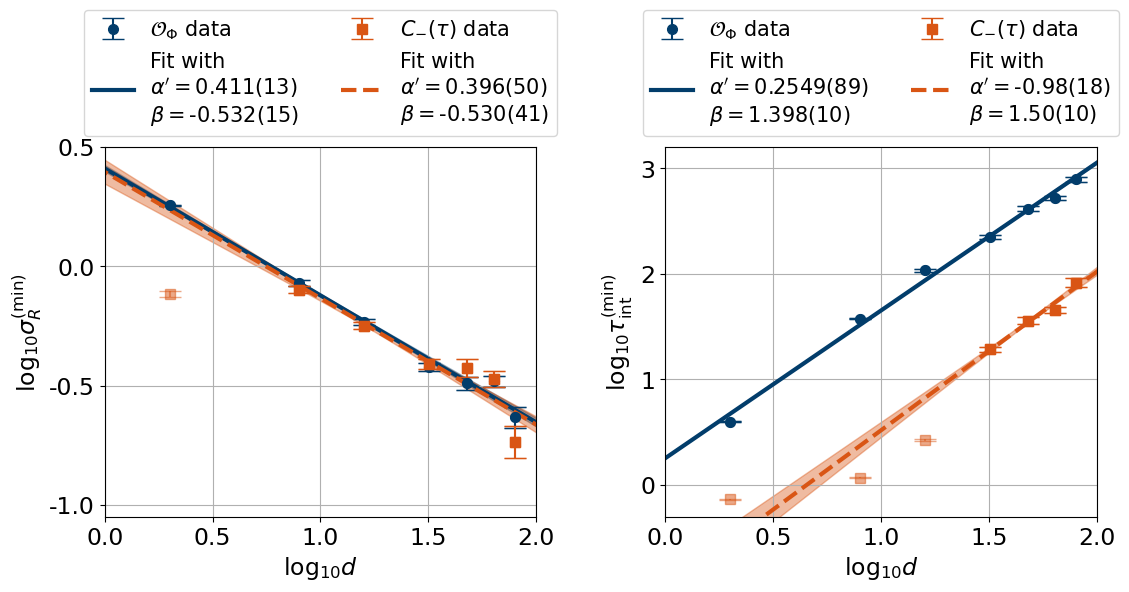

In [9]:
fs = 17 #24 with tex font
fs2 = 15 #19 with tex font
logfit = True
# logfit = False

weight_fits = False


use_obs_dict = {"TimeSliceRadius" : True, 
                "Charge" : False, 
                "Correlator" : True, 
                "sgndetM" : False
                }

lw = 3
markersize = 7
capsize = 8
n_bootstrap = 1000

ac_type_names = ["S1", "zc"]
ac_name = ac_type_names[0]
fig, ax = plt.subplots(1, 2, figsize = (12.8, 4.8))

cax = ax[0]
if use_obs_dict["TimeSliceRadius"]:
    csv_path = postpro_path + f"R2S_smin_tintmin_TimeSliceRadius_"+ac_name+"_weighted.csv"
    df = pd.read_csv(csv_path)
    data = df.to_numpy()
    Nt_ = data[:, 0]
    d_ = np.multiply(2, Nt_)
    obs0_smin, obs0_smin_err = data[:, 1], data[:, 2]
    plot_and_fit_sigmin(cax, d_, obs0_smin, obs0_smin_err, n_bootstrap = n_bootstrap, color = cs[0], marker = "o", obs_name = r"$\mathcal{O}_\Phi$ data", logfit = logfit, weight_fits = weight_fits, markersize = markersize, capsize = capsize, lw = lw)

if use_obs_dict["Charge"]:
    csv_path = postpro_path + f"R2S_smin_tintmin_Charge_"+ac_name+"_weighted.csv"
    df = pd.read_csv(csv_path)
    data = df.to_numpy()
    Nt_ = data[:, 0]
    d_ = np.multiply(2, Nt_)
    obs2_smin, obs2_smin_err = data[:, 1], data[:, 2]
    plot_and_fit_sigmin(cax, d_, obs2_smin, obs2_smin_err, n_bootstrap = n_bootstrap, color = cs[2], marker = "v", obs_name = r"$\mathcal{O}_Q$ data", logfit = logfit, weight_fits = weight_fits)

if use_obs_dict["Correlator"]:
    csv_path = postpro_path + f"R2S_smin_tintmin_Correlator_zc_max_weighted.csv"
    df = pd.read_csv(csv_path)
    data = df.to_numpy()
    Nt_ = data[:, 0]
    smin, smin_err = data[:, 1], data[:, 2]
    d_ = np.multiply(2, Nt_)
    n_start  = 1
    plot_and_fit_sigmin(cax, d_, smin, smin_err, n_bootstrap = n_bootstrap, color = cs[1], marker = "s", obs_name = r"$C_{-}(\tau)$ data", logfit = logfit, weight_fits = weight_fits, n_start = n_start, linestyle = "--", markersize = 7, capsize = capsize, lw = lw)

if use_obs_dict["sgndetM"]:
    csv_path = postpro_path + f"R2S_smin_tintmin_sgndetM_"+ac_name+"_weighted.csv"
    df = pd.read_csv(csv_path)
    data = df.to_numpy()
    Nt_ = data[:, 0]
    smin, smin_err = data[:, 1], data[:, 2]
    d_ = np.multiply(2, Nt_)
    n_start  = 0
    plot_and_fit_sigmin(cax, d_, smin, smin_err, n_bootstrap = n_bootstrap, color = cs[3], marker = "^", obs_name = r"$\mathcal{O}_f$ data", logfit = logfit, weight_fits = weight_fits, n_start = n_start)


cax.grid()

handles, labels = cax.get_legend_handles_labels()

tmp_handles = [handles[2], handles[0], handles[3], handles[1]]
tmp_labels = [labels[2], labels[0], labels[3], labels[1]]

cax.legend(tmp_handles, tmp_labels, loc = "upper center", bbox_to_anchor = (0.5, 1.4), ncol = 2, fontsize = fs2)
# cax.legend(tmp_handles, tmp_labels, loc = "lower center", bbox_to_anchor = (0.5, -0.63), ncol = 2, fontsize = fs2)


cax.tick_params(axis='x', labelsize=fs)
cax.tick_params(axis='y', labelsize=fs)
if logfit:
    cax.set_xlim(0, 2)
    cax.set_ylim(-1.05, 0.5)
    cax.set_xlabel(r"$\log_{10} d$", fontsize = fs)
    cax.set_ylabel(r"$\log_{10} \sigma_R^{(\mathrm{min})}$", fontsize = fs)
    # cax.set_title(r"$\log_{10}\sigma_R^{(\mathrm{min})}(d) = \alpha' + \beta \log_{10} d$", fontsize = fs, pad = 15)
    tmp = [0.5, 0.0, -0.5, -1.0]
    cax.set_yticks(tmp, [str(x) for x in tmp])
else:
    cax.set_xlabel(r"$d=N_xN_t$", fontsize = fs)
    cax.set_ylabel(r"$\sigma_R^{(\mathrm{min})}$", fontsize = fs)
    cax.set_xscale("log")
    cax.set_yscale("log")
    cax.set_xlim(1, 80)
    cax.set_ylim(0.1, 3)
    cax.set_yticks([1e-1, 1e0])
    cax.set_xticks([1e0, 1e1, 1e2])
    cax.set_title(r"Fit $\sigma_R^{(\mathrm{min})}(d) = \alpha d^\beta$", fontsize = fs, pad = 15)

    
tau_at_sigmin = np.zeros((2, 7))
tau_at_sigmin_err = np.zeros((2, 7))

ac_type_names = ["S1", "zc"]
ac_name = ac_type_names[0]

cax = ax[1]

if use_obs_dict["TimeSliceRadius"]:
    csv_path = postpro_path + f"R2S_smin_tintmin_TimeSliceRadius_"+ac_name+"_weighted.csv"
    df = pd.read_csv(csv_path)
    data = df.to_numpy()
    Nt_ = data[:, 0]
    tau_at_sigmin[1], tau_at_sigmin_err[1] = data[:, 3], data[:, 4]
    d_ = np.multiply(2, Nt_)
    plot_and_fit_sigmin(cax, d_, tau_at_sigmin[1], tau_at_sigmin_err[1], n_bootstrap = n_bootstrap, color = cs[0], marker = "o", obs_name = r"$\mathcal{O}_\Phi$ data", logfit = logfit, weight_fits = weight_fits, markersize = markersize, capsize = capsize, lw = lw)

if use_obs_dict["Charge"]:
    csv_path = postpro_path + f"R2S_smin_tintmin_Charge_"+ac_name+"_weighted.csv"
    df = pd.read_csv(csv_path)
    data = df.to_numpy()
    Nt_ = data[:, 0]
    tau_at_sigmin[0], tau_at_sigmin_err[0] = data[:, 3], data[:, 4]
    d_ = np.multiply(2, Nt_)
    plot_and_fit_sigmin(cax, d_, tau_at_sigmin[0], tau_at_sigmin_err[0], n_bootstrap = n_bootstrap, color = cs[2], marker = "v", obs_name = r"$\mathcal{O}_Q$ data", logfit = logfit, weight_fits = weight_fits)

if use_obs_dict["Correlator"]:
    csv_path = postpro_path + f"R2S_smin_tintmin_Correlator_zc_max_weighted.csv"
    df = pd.read_csv(csv_path)
    data = df.to_numpy()
    Nt_ = data[:, 0]
    tintmin, tintmin_err = data[:, 3], data[:, 4]
    d_ = np.multiply(2, Nt_)
    n_start  = 3 #1
    plot_and_fit_sigmin(cax, d_, tintmin, tintmin_err, n_bootstrap = n_bootstrap, color = cs[1], marker = "s", obs_name = r"$C_{-}(\tau)$ data", logfit = logfit, weight_fits = weight_fits, n_start = n_start, linestyle = "--", markersize = markersize, capsize = capsize, lw = lw)

if use_obs_dict["sgndetM"]:
    csv_path = f"R2S_smin_tintmin_sgndetM_"+ac_name+"_weighted.csv"
    df = pd.read_csv(csv_path)
    data = df.to_numpy()
    Nt_ = data[:, 0]
    tintmin, tintmin_err = data[:, 3], data[:, 4]
    d_ = np.multiply(2, Nt_)
    n_start  = 0
    plot_and_fit_sigmin(cax, d_, tintmin, tintmin_err, n_bootstrap = n_bootstrap, color = cs[3], marker = "^", obs_name = r"$\mathcal{O}_f$ data", logfit = logfit, weight_fits = weight_fits, n_start = n_start)


cax.grid()

handles, labels = cax.get_legend_handles_labels()
tmp_handles = [handles[2], handles[0], handles[3], handles[1]]
tmp_labels = [labels[2], labels[0], labels[3], labels[1]]

cax.legend(tmp_handles, tmp_labels, loc = "upper center", bbox_to_anchor = (0.5, 1.4), ncol = 2, fontsize = fs2)
# cax.legend(tmp_handles, tmp_labels, loc = "lower center", bbox_to_anchor = (0.5, -0.63), ncol = 2, fontsize = fs2)

# plt.ylim(1, 1000)
if logfit:
    cax.set_xlim(0, 2)
    cax.set_ylim(-0.3, 3.2)
    cax.set_xlabel(r"$\log_{10} d$", fontsize = fs)
    cax.set_ylabel(r"$\log_{10}\tau_{\mathrm{int}}^{(\mathrm{min})}$", fontsize = fs)
    cax.tick_params(axis = "both", labelsize = fs)
    tmp = [0, 1, 2, 3]
    cax.set_yticks(tmp)
    # cax.set_title(r"$\log_{10} \tau_{\mathrm{int}}^{(\mathrm{min})}(d)=\alpha' + \beta \log_{10}d$", fontsize = fs, pad = 15)
else:
    cax.set_xlabel(r"$d=N_xN_t$", fontsize = fs)
    cax.set_ylabel(r"$\tau_{\mathrm{int}}^{(\mathrm{min})}$", fontsize = fs)
    cax.set_yscale("log")
    cax.set_xscale("log")
    cax.set_xlim(1, 100)
    cax.set_ylim(0.5, 5000)
    cax.set_yticks([1e0, 1e1, 1e2, 1e3], [r"$10^{0}$", r"$10^{1}$", r"$10^{2}$", r"$10^{3}$"], fontsize = fs)
    cax.set_xticks([1e0, 1e1, 1e2], [r"$10^{0}$", r"$10^{1}$", r"$10^{2}$"], fontsize = fs)
    cax.set_title(r"Fit $\tau_{\mathrm{int}}^{(\mathrm{min})}(d)=\alpha d^\beta$", fontsize = fs, pad = 15)
# fig.suptitle(r"$N_x = 2$", fontsize = fs, y = 1.02)
fig.subplots_adjust(wspace = 0.3)
# plt.savefig(plot_path + "R2S_scaling.pdf", dpi = 300, bbox_inches = "tight")
plt.show()


# Plotting two-site correlator for $N_t = 40$ and compare to exact continuum solution

In [10]:
corr = np.array([0.46752, 0.37772, 0.30536, 0.24701, 0.19993, 0.16193, 0.13124,
       0.10646, 0.08644, 0.07027, 0.05722, 0.0467 , 0.03823, 0.03145,
       0.02604, 0.02178, 0.01847, 0.01597, 0.01418, 0.01303, 0.01247,
       0.01249, 0.0131 , 0.01435, 0.01631, 0.01909, 0.02284, 0.02779,
       0.03419, 0.0424 , 0.05286, 0.06616, 0.08303, 0.10439, 0.13143,
       0.16565, 0.20895, 0.26378, 0.33319, 0.4211 ])

tau = np.array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975])

(1001, 3)


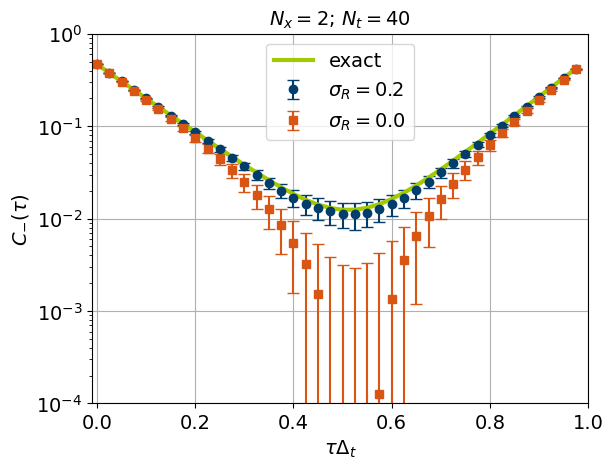

In [19]:
# # Load data for exact continuum solution
# path = data_path + "2siteU18B1.dat"
# df = pd.read_csv(path, sep = "\t", header = None)
# data = df.to_numpy()

ac_key = "_zc"
corr_ind = 0
Nt = 40
beta = 1.
sig = 0.2

path = postpro_path + f"Nt{Nt}/R2S_Nt{Nt}_sig"+str(sig).replace(".", "p")+f"_full_corr{corr_ind}_ac"+ac_key+".txt"
obs, stderr, tint, dtint, W = np.loadtxt(path, usecols = (0, 1, 2, 3, 4), skiprows = 1, unpack = True)
plt.errorbar(np.arange(0, len(obs), 1)*beta/Nt, obs, stderr, color = cs[0], linestyle = "", marker = "o", capsize = 4, label = rf"$\sigma_R = {sig}$")

sig = 0.0

path = postpro_path + f"Nt{Nt}/R2S_Nt{Nt}_sig"+str(sig).replace(".", "p")+f"_full_corr{corr_ind}_ac"+ac_key+".txt"
obs, stderr, tint, dtint, W = np.loadtxt(path, usecols = (0, 1, 2, 3, 4), skiprows = 1, unpack = True)
plt.errorbar(np.arange(0, len(obs), 1)*beta/Nt, obs, stderr, color = cs[1], linestyle = "", marker = "s", capsize = 4, label = rf"$\sigma_R = {sig}$")


# plt.plot(data[:, 0], data[:, 2], linestyle = "-", marker = "", linewidth = 3, color = cs[2], label = "exact continuum") # exact continuum result
plt.plot(tau, corr, linestyle = "-", marker = "", linewidth = 3, color = cs[2], label = "exact") # exact result accounting for discretization effects
fs = 14

plt.legend(loc = "upper center", fontsize = fs)
plt.grid()
plt.yscale("log")
plt.xlabel(r"$\tau\Delta_t$", fontsize = fs)
plt.ylabel(r"$C_{-}(\tau)$", fontsize = fs)
plt.ylim(1e-4, 1e0)
plt.xlim(-0.01, 1.)
plt.tick_params(axis='both', which='major', labelsize=fs)
plt.title(r"$N_x = 2$; $N_t = 40$", fontsize = fs)
# plt.savefig(plot_path + "R2S_correlator_comparison.pdf", dpi = 300, bbox_inches = "tight")
plt.show()
